# Exploratory Data Analysis for SETI Signal Detection

In this notebook, we will explore the dataset provided by the Breakthrough Listen team and gain insights into the data to help us develop an effective algorithm for detecting potential technosignatures of extraterrestrial intelligence.


In [59]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [60]:
# Import custom dataset class
from dataset import SETIDataset

In [61]:
# Load the dataset
root_dir = "E:\seti-breakthrough-listen\\data\\train"
labels_csv = "E:\seti-breakthrough-listen\\data\\train_labels.csv"

dataset = SETIDataset(root_dir=root_dir, labels_csv=labels_csv)  # Create the dataset object

In [62]:
# Split the dataset into train and validation sets
train_indices, val_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42, stratify=dataset.labels.iloc[:, 1])

train_dataset = SETIDataset(root_dir=root_dir, labels_csv=labels_csv)
val_dataset = SETIDataset(root_dir=root_dir, labels_csv=labels_csv)

In [63]:
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=torch.utils.data.SubsetRandomSampler(train_indices), num_workers=4, prefetch_factor=2)
val_dataloader = DataLoader(val_dataset, batch_size=32, sampler=torch.utils.data.SubsetRandomSampler(val_indices), num_workers=4, prefetch_factor=2)

In [64]:
# Check the distribution of labels
label_counts = dataset.labels.iloc[:, 1].value_counts()
print("Label distribution:")
print(label_counts)

Label distribution:
0    54000
1     6000
Name: target, dtype: int64


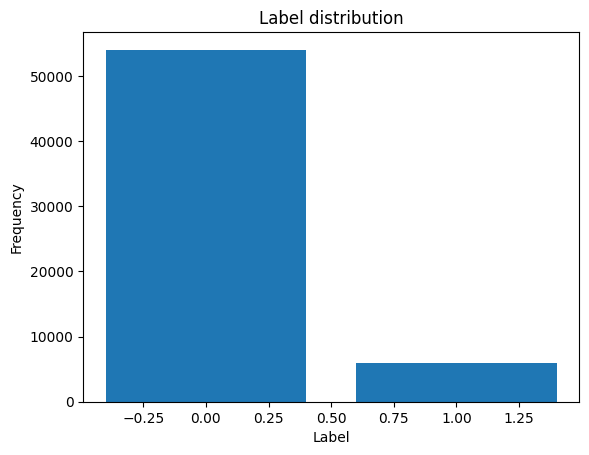

In [65]:
plt.bar(label_counts.index, label_counts.values)
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.title("Label distribution")
plt.show()

In [66]:
def plot_spectrogram(spectrogram, title):
    plt.figure(figsize=(12, 6))
    plt.imshow(spectrogram.T, aspect='auto', origin='lower', cmap='viridis')  # Transpose the input data
    plt.xlabel('Time Steps')  # Update the x-axis label
    plt.ylabel('Frequency Channels')  # Update the y-axis label
    plt.title(title)
    plt.colorbar()
    plt.show()


file_path: E:\seti-breakthrough-listen\data\train\3\39d4501894c8d1d.npy


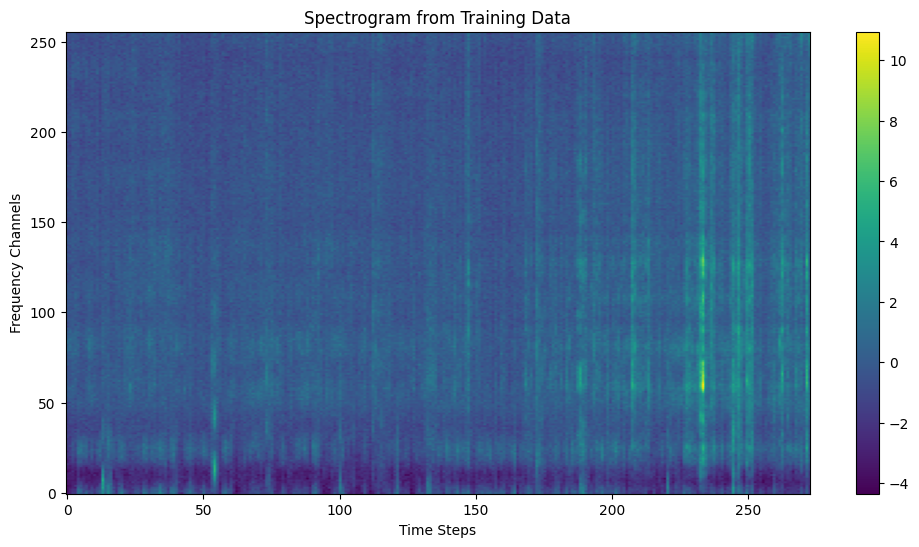

In [79]:
index = np.random.randint(len(train_dataset))
spectrogram, _ = train_dataset[index]  # Get the spectrogram and ignore the label
plot_spectrogram(spectrogram[0], 'Spectrogram from Training Data')  # Display the first channel of the spectrogram

file_path: E:\seti-breakthrough-listen\data\train\0\03a7baa947403eb.npy


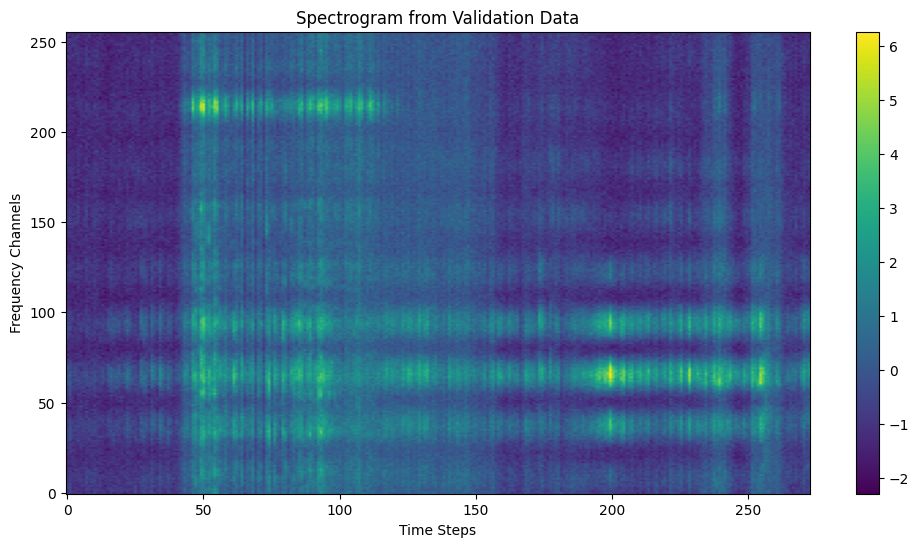

In [78]:
index = np.random.randint(len(train_dataset))
spectrogram, _ = val_dataset[index]  # Get the spectrogram and ignore the label
plot_spectrogram(spectrogram[0], 'Spectrogram from Validation Data')  # Display the first channel of the spectrogram

file_path: E:\seti-breakthrough-listen\data\train\0\0000799a2b2c42d.npy
file_path: E:\seti-breakthrough-listen\data\train\0\00042890562ff68.npy
file_path: E:\seti-breakthrough-listen\data\train\0\0005364cdcb8e5b.npy
file_path: E:\seti-breakthrough-listen\data\train\0\0007a5a46901c56.npy
file_path: E:\seti-breakthrough-listen\data\train\0\0009283e145448e.npy
file_path: E:\seti-breakthrough-listen\data\train\0\00096524e6670d6.npy
file_path: E:\seti-breakthrough-listen\data\train\0\000cd479c2106d4.npy
file_path: E:\seti-breakthrough-listen\data\train\0\000e869ed875e40.npy
file_path: E:\seti-breakthrough-listen\data\train\0\00104dc954c2d30.npy
file_path: E:\seti-breakthrough-listen\data\train\0\0010ad3ece01536.npy
file_path: E:\seti-breakthrough-listen\data\train\0\00118f68d95f846.npy
file_path: E:\seti-breakthrough-listen\data\train\0\0012dcc6bd1691a.npy
file_path: E:\seti-breakthrough-listen\data\train\0\0012ef703e41ef0.npy
file_path: E:\seti-breakthrough-listen\data\train\0\00139e3001fa

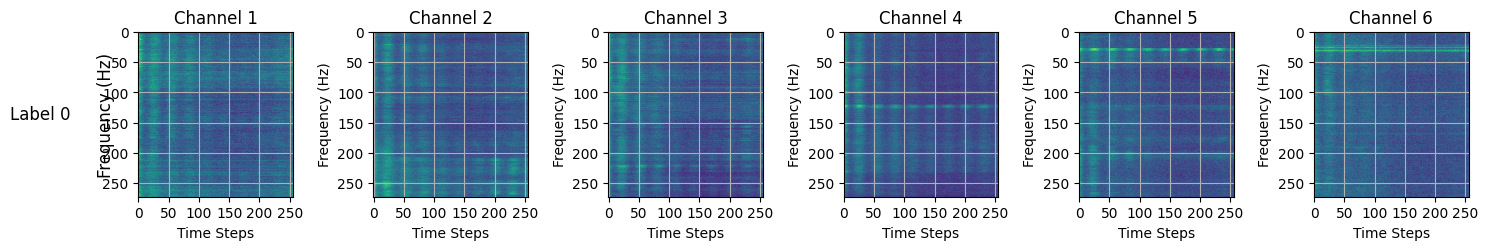

file_path: E:\seti-breakthrough-listen\data\train\0\0024012d1431fbc.npy


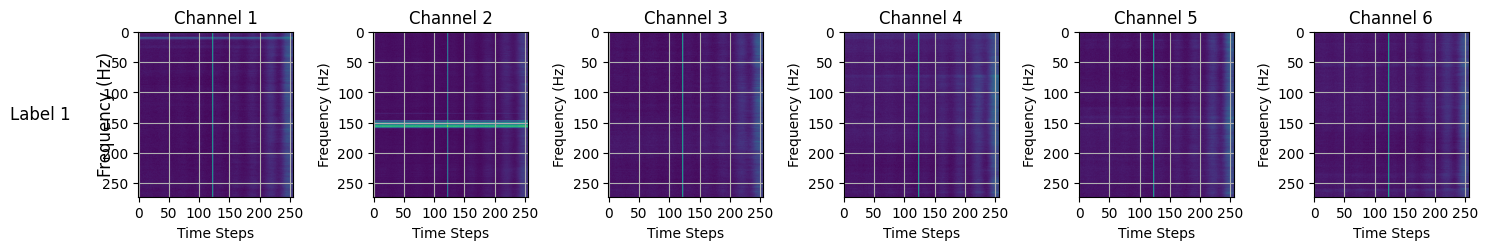

In [70]:
def plot_single_example(dataset, example_index, num_channels=6, figsize=(15, 5)):
    fig, axs = plt.subplots(1, num_channels, figsize=figsize)
    data, label = dataset[example_index]

    for ch in range(num_channels):
        im = axs[ch].imshow(data[ch], cmap="viridis")
        axs[ch].set_xticks(np.arange(0, data[ch].shape[1], 50))
        axs[ch].set_yticks(np.arange(0, data[ch].shape[0], 50))

        axs[ch].set_title(f"Channel {ch + 1}")
        if ch == 0:
            axs[ch].set_ylabel(f"Sample {example_index}", fontsize=12)
            axs[ch].yaxis.set_label_coords(-0.15, 0.5)
            axs[ch].annotate(f"Label {label}", xy=(0, 0.5), xytext=(-axs[ch].yaxis.labelpad - 15, 0),
                             xycoords=axs[ch].yaxis.label, textcoords='offset points',
                             fontsize=12, ha='right', va='center')
        axs[ch].set_xlabel("Time Steps")
        axs[ch].set_ylabel("Frequency (Hz)")
        axs[ch].xaxis.set_tick_params(labelbottom=True)
        axs[ch].yaxis.set_tick_params(labelleft=True)
        axs[ch].grid(True)

    plt.tight_layout()
    plt.show()

non_seti_idx, seti_idx = find_example_indices(dataset)
plot_single_example(dataset, example_index=non_seti_idx)
plot_single_example(dataset, example_index=seti_idx)

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.fft import fft
from scipy.signal import correlate

# Find example indices and extract a subset of non-SETI and SETI signals
non_seti_idx, seti_idx = find_example_indices(dataset)

non_seti_data, _ = dataset[non_seti_idx]
seti_data, _ = dataset[seti_idx]

subset_size = 50  # Adjust this value based on the dataset size and available resources
non_seti_subset = [dataset[i][0] for i in range(non_seti_idx, non_seti_idx + subset_size)]
seti_subset = [dataset[i][0] for i in range(seti_idx, seti_idx + subset_size)]


file_path: E:\seti-breakthrough-listen\data\train\0\0000799a2b2c42d.npy
file_path: E:\seti-breakthrough-listen\data\train\0\00042890562ff68.npy
file_path: E:\seti-breakthrough-listen\data\train\0\0005364cdcb8e5b.npy
file_path: E:\seti-breakthrough-listen\data\train\0\0007a5a46901c56.npy
file_path: E:\seti-breakthrough-listen\data\train\0\0009283e145448e.npy
file_path: E:\seti-breakthrough-listen\data\train\0\00096524e6670d6.npy
file_path: E:\seti-breakthrough-listen\data\train\0\000cd479c2106d4.npy
file_path: E:\seti-breakthrough-listen\data\train\0\000e869ed875e40.npy
file_path: E:\seti-breakthrough-listen\data\train\0\00104dc954c2d30.npy
file_path: E:\seti-breakthrough-listen\data\train\0\0010ad3ece01536.npy
file_path: E:\seti-breakthrough-listen\data\train\0\00118f68d95f846.npy
file_path: E:\seti-breakthrough-listen\data\train\0\0012dcc6bd1691a.npy
file_path: E:\seti-breakthrough-listen\data\train\0\0012ef703e41ef0.npy
file_path: E:\seti-breakthrough-listen\data\train\0\00139e3001fa

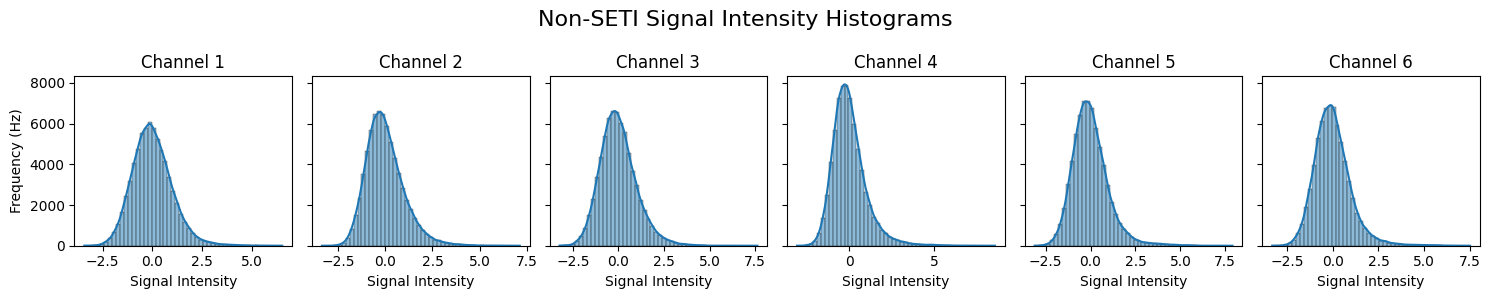

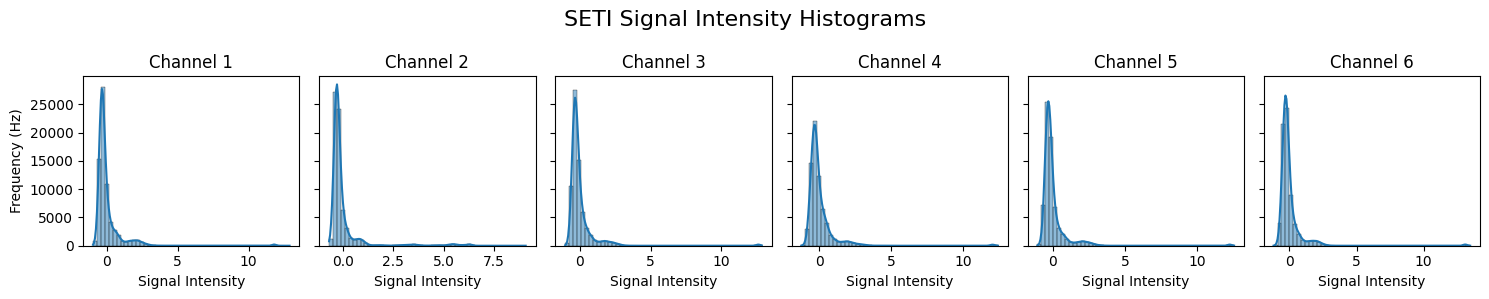

In [72]:
def plot_histograms(data, title):
    num_channels = data.shape[0]
    fig, axs = plt.subplots(1, num_channels, figsize=(15, 3), sharey=True)
    for ch in range(num_channels):
        sns.histplot(data[ch].flatten(), ax=axs[ch], bins=50, kde=True)
        axs[ch].set_title(f"Channel {ch + 1}")
        axs[ch].set_xlabel("Signal Intensity")
    axs[0].set_ylabel("Frequency (Hz)")
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_histograms(non_seti_data, "Non-SETI Signal Intensity Histograms")
plot_histograms(seti_data, "SETI Signal Intensity Histograms")


In [73]:
def print_mean_std(data, label):
    num_channels = data.shape[0]
    print(f"{label} Signal Mean and Standard Deviation:")
    for ch in range(num_channels):
        mean = data[ch].mean()
        std = data[ch].std()
        print(f"Channel {ch + 1}: Mean = {mean:.2f}, Standard Deviation = {std:.2f}")

print_mean_std(non_seti_data, "Non-SETI")
print_mean_std(seti_data, "SETI")


Non-SETI Signal Mean and Standard Deviation:
Channel 1: Mean = 0.00, Standard Deviation = 1.00
Channel 2: Mean = -0.00, Standard Deviation = 1.00
Channel 3: Mean = -0.00, Standard Deviation = 1.00
Channel 4: Mean = 0.00, Standard Deviation = 1.00
Channel 5: Mean = 0.00, Standard Deviation = 1.00
Channel 6: Mean = -0.00, Standard Deviation = 1.00
SETI Signal Mean and Standard Deviation:
Channel 1: Mean = 0.00, Standard Deviation = 1.00
Channel 2: Mean = 0.00, Standard Deviation = 1.00
Channel 3: Mean = -0.00, Standard Deviation = 1.00
Channel 4: Mean = 0.00, Standard Deviation = 1.00
Channel 5: Mean = -0.00, Standard Deviation = 1.00
Channel 6: Mean = -0.00, Standard Deviation = 1.00


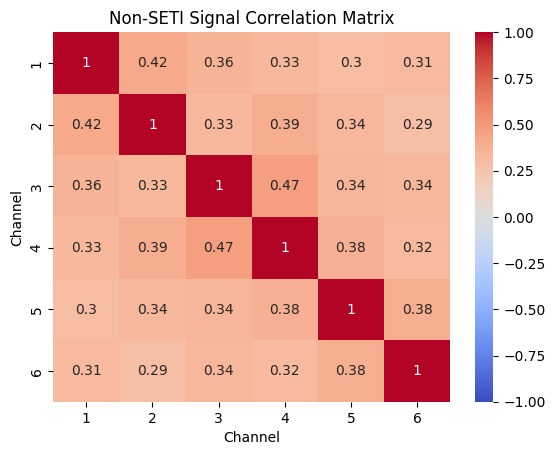

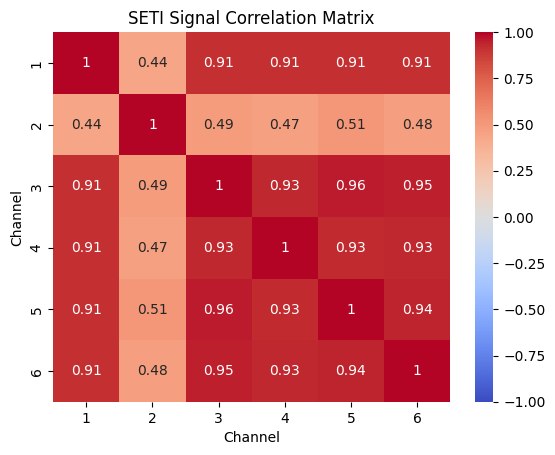

In [74]:
def plot_correlation_matrix(data, title):
    num_channels = data.shape[0]
    corr_matrix = np.corrcoef(data.reshape(num_channels, -1))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(title)
    plt.xlabel("Channel")
    plt.ylabel("Channel")
    plt.xticks(ticks=np.arange(0.5, num_channels), labels=np.arange(1, num_channels + 1))
    plt.yticks(ticks=np.arange(0.5, num_channels), labels=np.arange(1, num_channels + 1))
    plt.show()

plot_correlation_matrix(non_seti_data, "Non-SETI Signal Correlation Matrix")
plot_correlation_matrix(seti_data, "SETI Signal Correlation Matrix")


We use the Fast Fourier Transform (FFT) to analyze the frequency content of the signals. FFT converts a time-domain signal into its frequency-domain representation, showing which frequencies are present in the signal and their amplitudes. By plotting the FFT results, we can compare the frequency content of non-SETI and SETI signals, potentially identifying unique patterns or differences between the two signal types

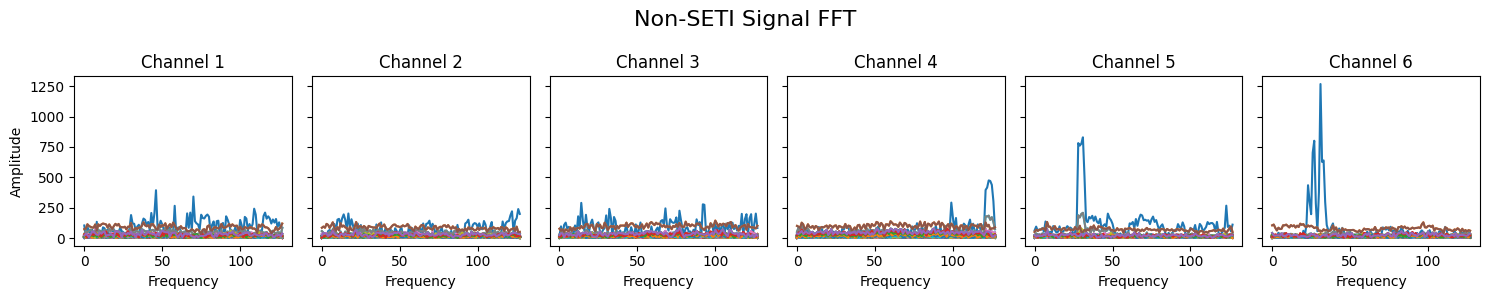

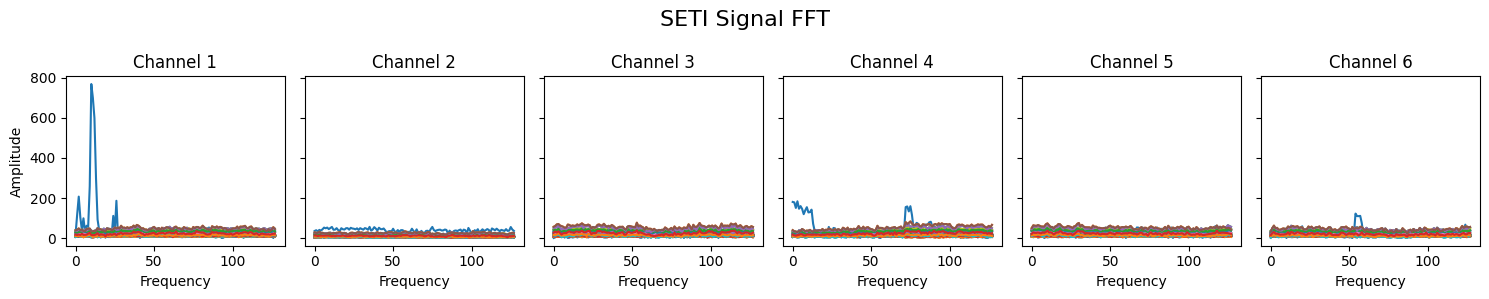

In [75]:
def plot_fft(data, title):
    num_channels = data.shape[0]
    fig, axs = plt.subplots(1, num_channels, figsize=(15, 3), sharey=True)
    for ch in range(num_channels):
        y = np.abs(fft(data[ch]))[:data[ch].shape[1] // 2]
        x = np.arange(len(y))
        axs[ch].plot(x, y)
        axs[ch].set_title(f"Channel {ch + 1}")
        axs[ch].set_xlabel("Frequency")
    axs[0].set_ylabel("Amplitude")
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_fft(non_seti_data, "Non-SETI Signal FFT")
plot_fft(seti_data, "SETI Signal FFT")


In [76]:
# Combine non-SETI and SETI subsets and create labels
combined_data = np.array(non_seti_subset + seti_subset)
labels = np.array([0] * len(non_seti_subset) + [1] * len(seti_subset))

# Flatten data and apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_data.reshape(combined_data.shape[0], -1))

sample_size = 100  # Adjust this value based on your system's memory capacity
random_indices = np.random.choice(np.arange(combined_data.shape[0]), size=sample_size, replace=False)
sampled_data = combined_data[random_indices]

pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_data.reshape(combined_data.shape[0], -1))

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, method='barnes_hut')
tsne_result = tsne.fit_transform(sampled_data.reshape(sampled_data.shape[0], -1))


Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE) are dimensionality reduction techniques that help visualize high-dimensional data in lower dimensions (in our case, 2D). By applying PCA and t-SNE to a combined dataset of non-SETI and SETI signals, we can observe how well these methods can separate the signals based on their features. This may provide insights into whether the data can be effectively classified using machine learning algorithms.

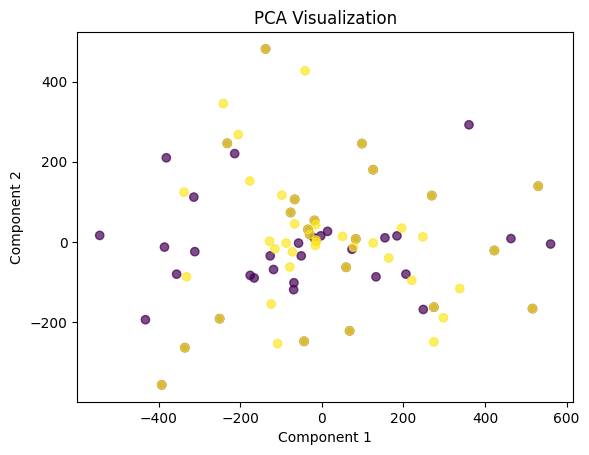

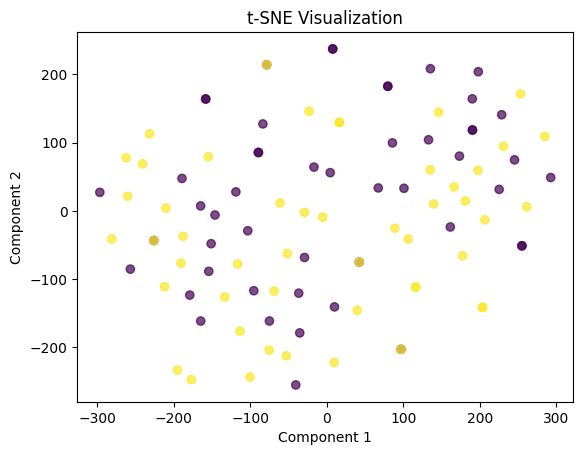

In [77]:
def plot_scatter(x, y, labels, title):
    plt.scatter(x, y, c=labels, cmap='viridis', alpha=0.7)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(title)
    plt.show()

plot_scatter(pca_result[:, 0], pca_result[:, 1], labels, "PCA Visualization")
plot_scatter(tsne_result[:, 0], tsne_result[:, 1], labels, "t-SNE Visualization")
